In [148]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import norm

In [149]:
if not os.path.exists('image'):
    os.makedirs('image')

# EXP3

In [150]:
# Function to generate random means
def generate_means(N, mean_load, var_load):
    print('Mean Load:', mean_load, '; Variance Load:', var_load)
    means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)

    # Plotting means_load
    plt.figure(figsize=(12, 6))
    plt.plot(means_load, marker='o', linestyle='-', color='b', label='means_load')
    plt.title('Random Means for Load')
    plt.xlabel('Node')
    plt.ylabel('Mean Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return means_load

In [151]:
# Function to generate IID data
def generate_iid_data(N, T, means_load):
    loads = np.array([np.random.normal(loc=means_load[i], scale=1, size=T) for i in range(N)])

    return loads, np.mean(loads, axis=1)

In [152]:
# Function to generate AR(1) data
def generate_ar1_data(N, T, means_load, theta):
    """
    Generate AR(1) data for multiple nodes.
    
    Parameters:
        N (int): Number of nodes.
        T (int): Number of time steps.
        means_load (array-like): Mean load for each node.
        theta (float): AR(1) process parameter.
    
    Returns:
        load (ndarray): Generated AR(1) load data.
    """
    # print('Theta:', theta)
    loads = np.zeros((N, T))

    def generate_ar1(theta, T, mean_node):
        """
        Generate a single AR(1) time series.
        
        Parameters:
            theta (float): AR(1) process parameter.
            n (int): Number of time steps.
            mean_node (float): Mean load for the node.
        
        Returns:
            ar1 (ndarray): Generated AR(1) time series.
        """
        ar1 = np.zeros(T)
        ar1[0] = mean_node
        for t in range(1, T):
            ar1[t] = theta * ar1[t - 1] + (1 - theta) * mean_node + np.random.normal(0, 1)
        return ar1

    for i in range(N):
        loads[i] = generate_ar1(theta, T, means_load[i])

    return loads, np.mean(loads, axis=1)

In [153]:
def calculate_reward_0(load):
    # Simple reward function
    return 1 / ( 1 + load_iid)

线性反转缩放 Linear inverse scaling

In [154]:
def calculate_reward(load, alpha=1):
    # Linear inverse scaling reward function.
    return (np.max(load) - load) / (np.max(load) - np.min(load)) * alpha

Mean Load: 50 ; Variance Load: 10


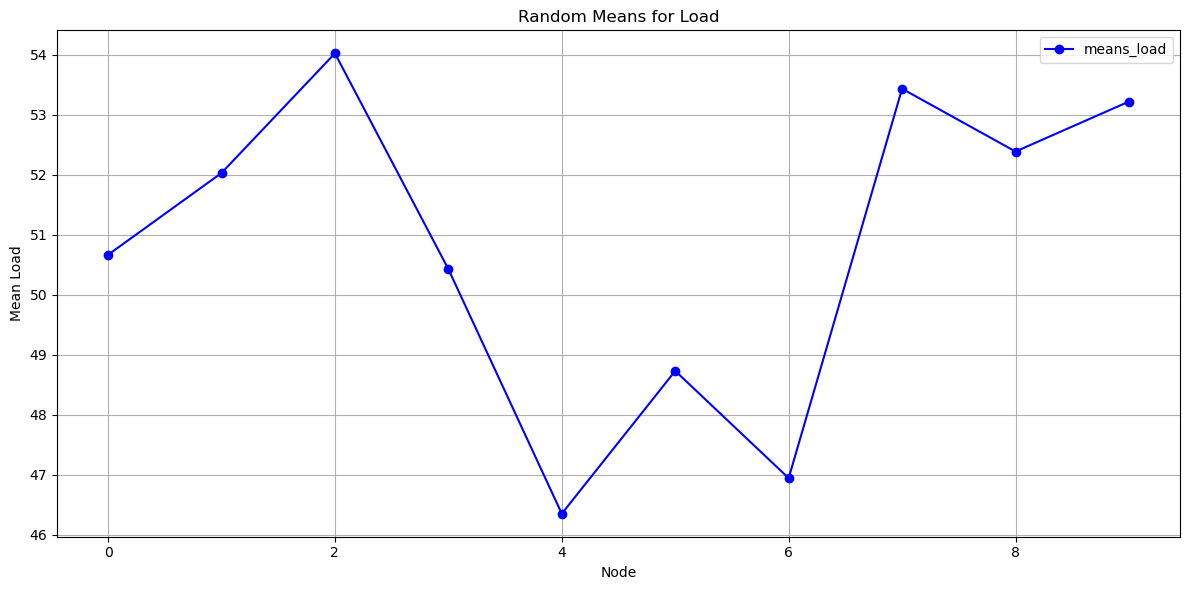

In [155]:
N = 10
T = 1000
mean_load = 50
var_load = 10
k_values = [1, 2, 5]
thetas = [0.1, 0.5, 0.9]

means_load = generate_means(N, mean_load, var_load)

# Generate IID data
load_iid, load_iid_means = generate_iid_data(N, T, means_load)

load_reward_iid = calculate_reward(load_iid, 10)
# load_reward_iid_means = calculate_reward(load_iid_means, 10)

# Generate AR(1) data
# load_ar1, load_ar1_means = generate_ar1_data(N, T, means_load, theta)
load_ar1_thetas = []
load_ar1_means_thetas = []
load_reward_ar1_thetas = []
load_reward_ar1_means_thetas = []
for theta in thetas:
    load_ar1_theta, load_ar1_means_theta = generate_ar1_data(N, T, means_load, theta)
    
    load_reward_ar1_theta = calculate_reward(load_ar1_theta, 10)
    # load_reward_ar1_means_theta = calculate_reward(load_ar1_means_theta, 10)
    
    load_ar1_thetas.append(load_ar1_theta)
    load_ar1_means_thetas.append(load_ar1_means_theta)
    load_reward_ar1_thetas.append(load_reward_ar1_theta)
    # load_reward_ar1_means_thetas.append(load_reward_ar1_means_theta)

In [156]:
def plot_combined(data, title):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    time = np.arange(data.shape[1])

    # Plot distributions (left subplot)
    for i in range(data.shape[0]):
        mean = np.mean(data[i])
        std = np.std(data[i])
        x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
        p = norm.pdf(x, mean, std)
        axs[0].plot(x, p, label=f'Node {i + 1}')
    axs[0].set_title(f'{title} - Distribution')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Density')
    axs[0].legend()
    axs[0].grid(True)

    def exponential_moving_average(data, alpha):
        ema = np.zeros_like(data)
        ema[0] = data[0]
        for t in range(1, len(data)):
            ema[t] = alpha * data[t] + (1 - alpha) * ema[t - 1]
        return ema

    # Plot smoothed time series (right subplot)
    for i in range(data.shape[0]):
        smoothed_data = savgol_filter(data[i], window_length=51, polyorder=3)
        axs[1].plot(time, smoothed_data, label=f'Node {i + 1}')
    axs[1].set_title(f'{title} - Time Series')
    axs[1].set_xlabel('Time (T)')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    fig.savefig(f'image/{title}.png')
    plt.show()

In [157]:
# plot_combined(load_iid, 'IID Data; Load')
# for i, theta in enumerate(thetas):
#     plot_combined(load_ar1_thetas[i], f'AR(1) Data, Theta = {theta}; Load')

In [158]:
# plot_combined(load_reward_iid, 'IID Data; Load Reward')
# for i, theta in enumerate(thetas):
#     plot_combined(load_reward_ar1_thetas[i], f'AR(1) Data, Theta = {theta}; Load Reward')

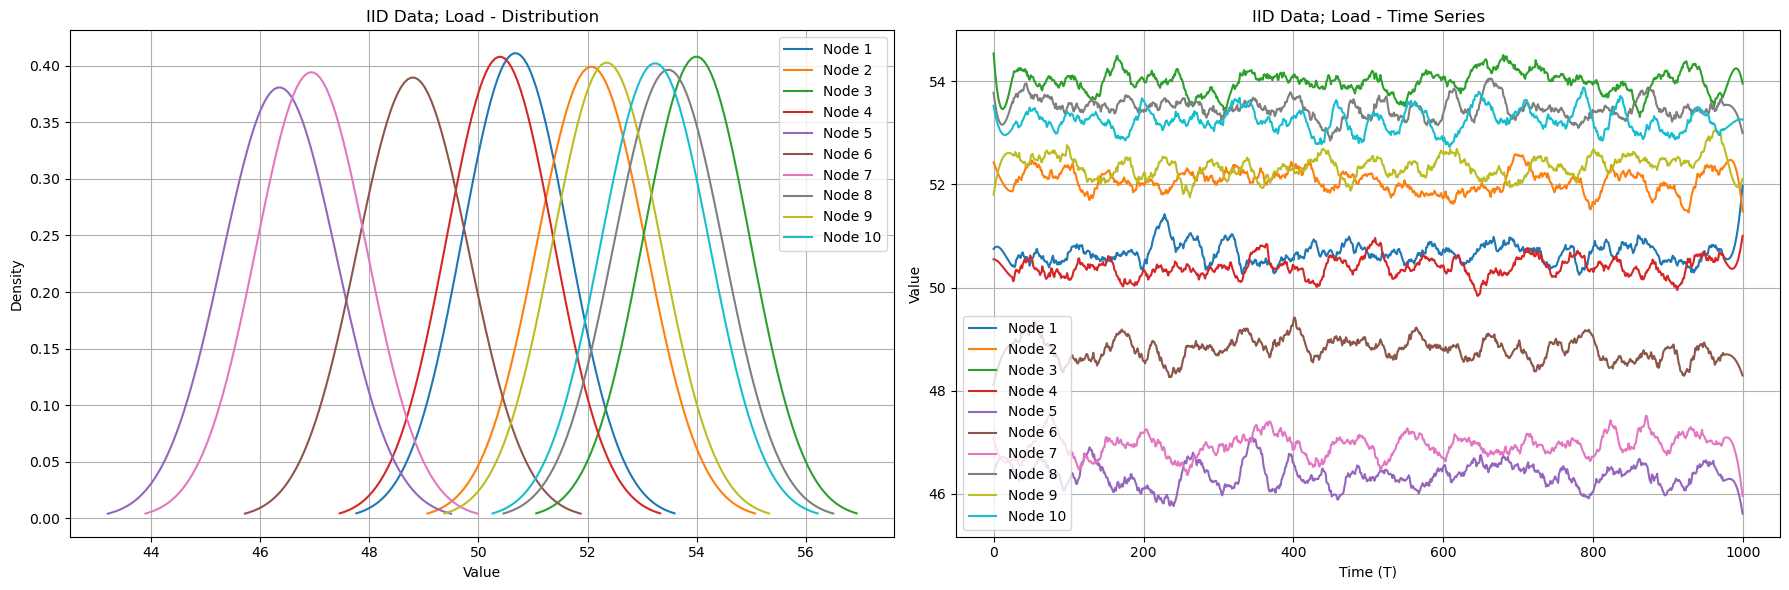

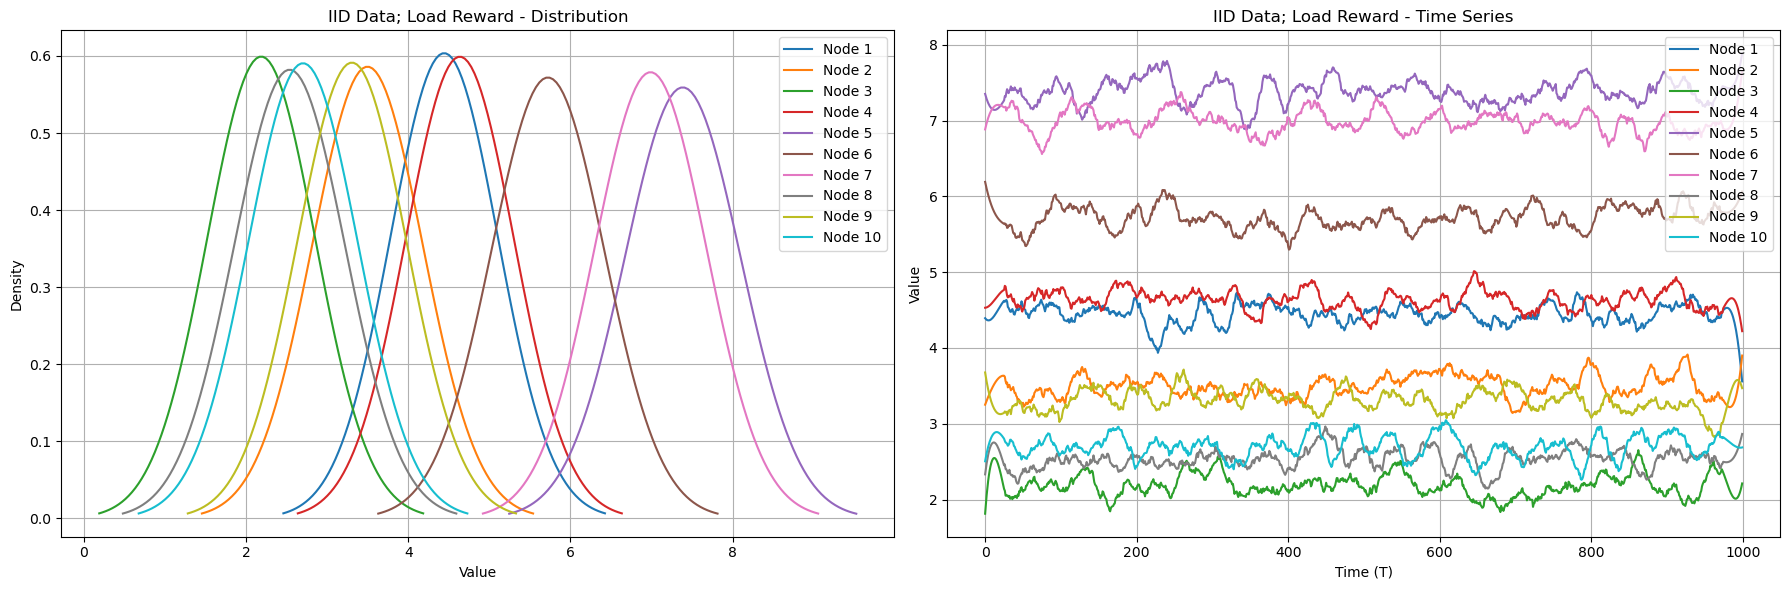

In [159]:
plot_combined(load_iid, 'IID Data; Load')
plot_combined(load_reward_iid, 'IID Data; Load Reward')

# Plot

In [160]:
def plot_results(actions, regrets, accuracies, gammas, k_values, title):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Plot smoothed single-step regrets
    for i, gamma in enumerate(gammas):
        smoothed_single_step_regrets = savgol_filter(regrets[i], window_length=101, polyorder=2)
        axs[0].plot(smoothed_single_step_regrets, label=f'Gamma {gamma}')
    axs[0].set_title('Smoothed Single-Step Regrets')
    axs[0].set_xlabel('Time Steps')
    axs[0].set_ylabel('Regret')
    axs[0].legend()
    axs[0].grid(True)

    # Plot smoothed cumulative regrets
    for i, gamma in enumerate(gammas):
        smoothed_cumulative_regrets = savgol_filter(np.cumsum(regrets[i]), window_length=51, polyorder=3)
        axs[1].plot(smoothed_cumulative_regrets, label=f'Gamma {gamma}')
    axs[1].set_title('Smoothed Cumulative Regrets')
    axs[1].set_xlabel('Time Steps')
    axs[1].set_ylabel('Cumulative Regret')
    axs[1].legend()
    axs[1].grid(True)

    # Plot top-k accuracy
    width = 0.15
    x = np.arange(len(k_values))

    for i, gamma in enumerate(gammas):
        top_k_accuracies = [accuracies[i][k] for k in k_values]
        bars = axs[2].bar(x + i * width, top_k_accuracies, width, label=f'Gamma {gamma}')
        for bar in bars:
            yval = bar.get_height()
            axs[2].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')
    axs[2].set_title('Top-k Accuracy')
    axs[2].set_xlabel('Top-k')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_xticks(x + width * (len(gammas) - 1) / 2)
    axs[2].set_xticklabels(k_values)
    axs[2].legend()
    axs[2].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    fig.savefig(f'image/{title}.png')
    plt.show()

In [161]:
def plot_actions(actions, title):
    num_plots = len(actions)
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 6 * num_plots), constrained_layout=True)

    for i, ax in enumerate(axs):
        ax.plot(actions[i], marker='o', linestyle='-', color='b', label=f'Chosen Arms (gamma={i+1})')
        ax.set_title(f'{title} - Chosen Arms (gamma={i+1})')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Chosen Arm')
        ax.legend()
        ax.grid(True)
        
    fig.savefig(f'image/{title}.png')
    plt.show()

# EXP3 Algorithm

In [162]:
def calculate_top_k_accuracy(actions, rewards_means, k):
    optimal_actions = np.argsort(rewards_means)[::-1][:k]
    # print(f'Optimal Actions: {optimal_actions}')
    return np.mean(np.isin(actions, optimal_actions))

In [163]:
# EXP3 Algorithm
def exp3(rewards, gammas, k_values):
    N, T = rewards.shape
    rewards_means = np.mean(rewards, axis=1)

    optimal_reward = np.max(rewards_means)
    optimal_action = np.argmax(rewards_means)
    print(f'Optimal Action: {optimal_action}, Optimal Reward: {optimal_reward}')

    all_regrets = []
    all_actions = []
    all_accuracies = []

    for gamma in gammas:

        weights = np.ones(N)
        counts = np.zeros(N)
        probabilities = np.zeros(N)
        actions = []
        regrets = []

        for t in range(T):
            probabilities = (1 - gamma) * (weights / np.sum(weights)) + gamma / N
            # print(f'{t}: {probabilities}')
            action = np.random.choice(N, p=probabilities)
            reward = rewards[action, t]
            estimated_reward = reward / probabilities[action]
            weights[action] *= np.exp(gamma * estimated_reward / N)
            # estimated_reward = np.clip(reward / probabilities[action], 0, 1000)
            # weights[action] *= np.exp(np.clip(gamma * estimated_reward / N, 0, 100))
            counts[action] += 1
            regret = optimal_reward - reward
            # print(f'{t}: {action}, {optimal_reward}, {reward}, {regret}')

            regrets.append(regret)
            actions.append(action)

        all_regrets.append(regrets)
        all_actions.append(actions)

        accuracies = {k: calculate_top_k_accuracy(actions, rewards_means, k) for k in k_values}
        all_accuracies.append(accuracies)

    return all_actions, all_regrets, all_accuracies

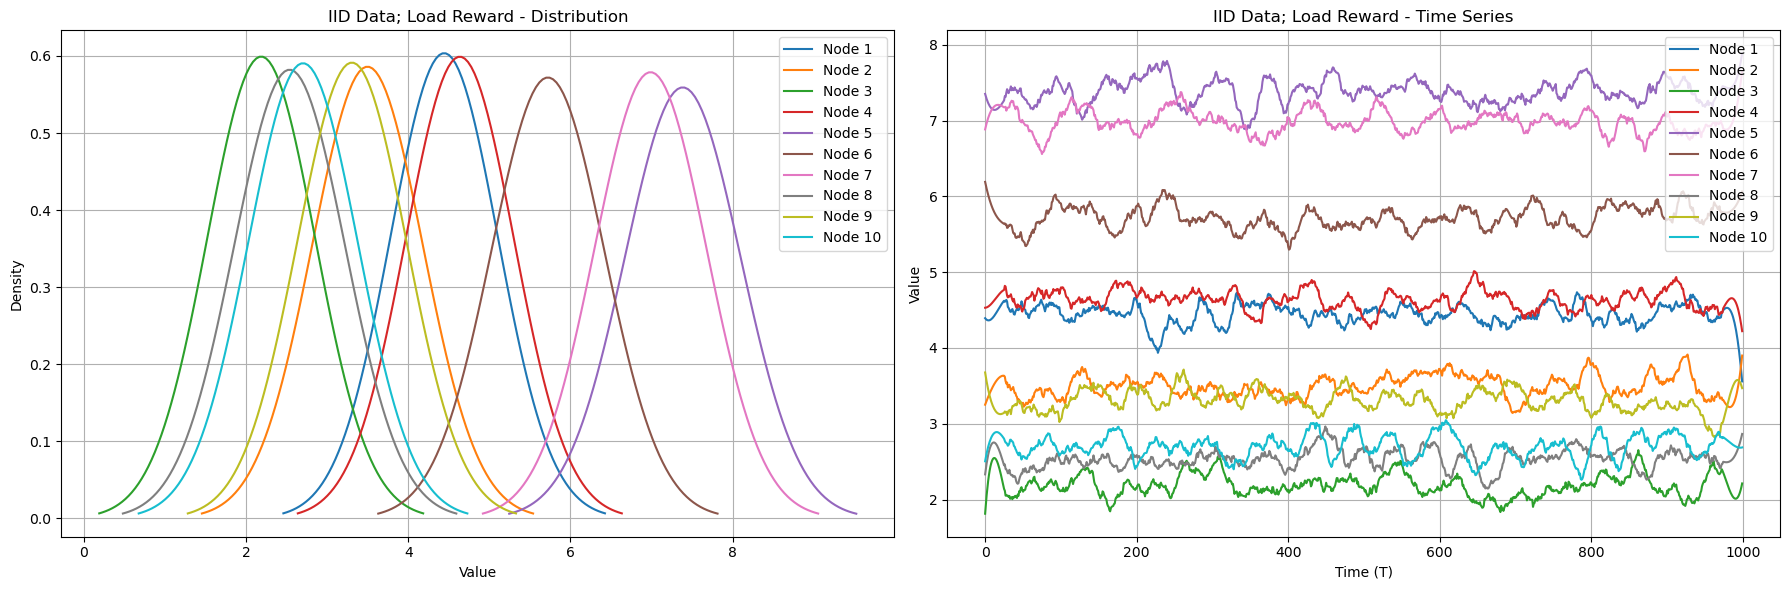

In [164]:
plot_combined(load_reward_iid, 'IID Data; Load Reward')

In [165]:
gammas = [0.01, 0.05, 0.1, 0.15, 0.2]

Optimal Action: 4, Optimal Reward: 7.385151020311732


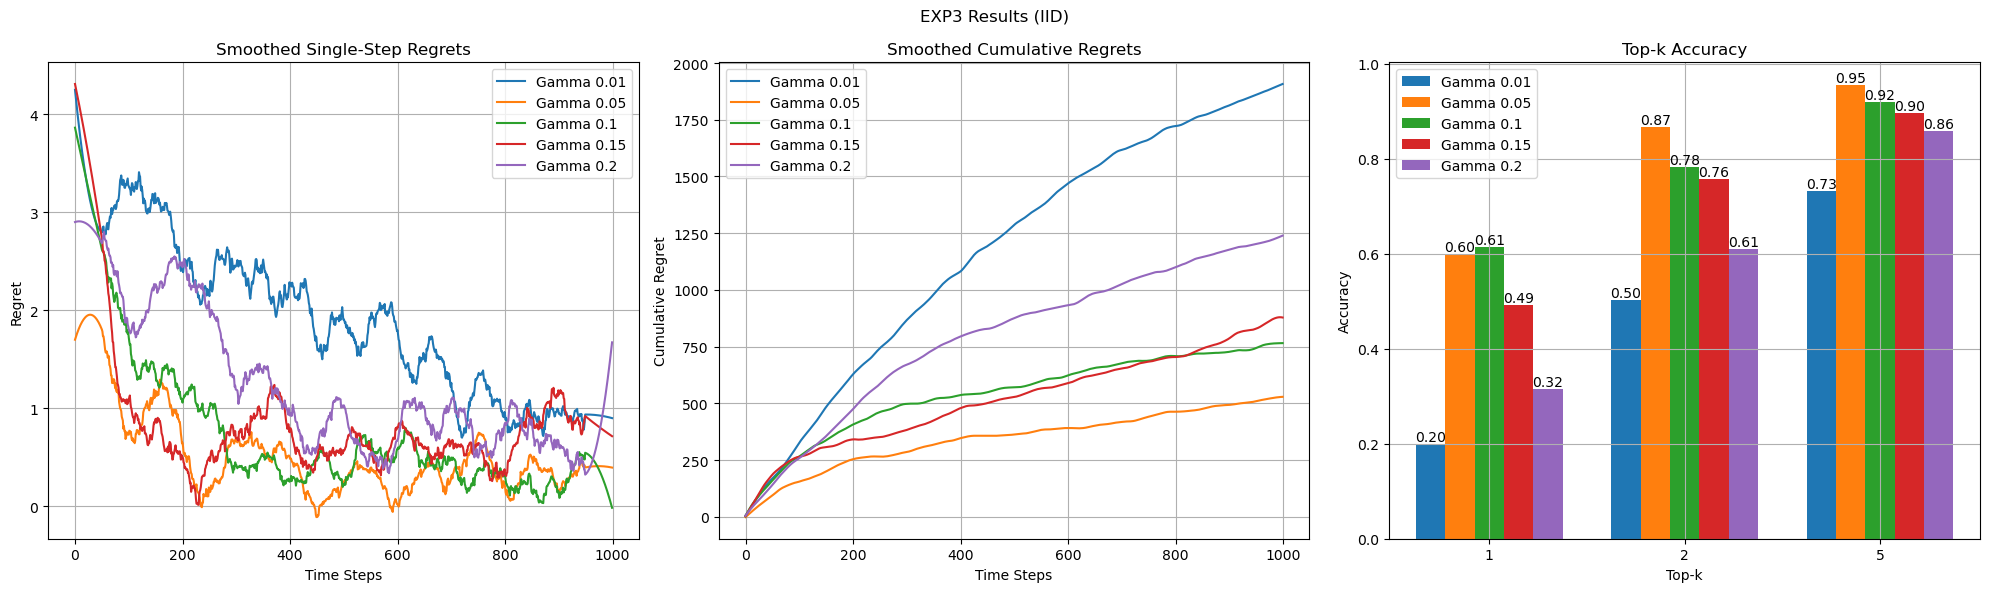

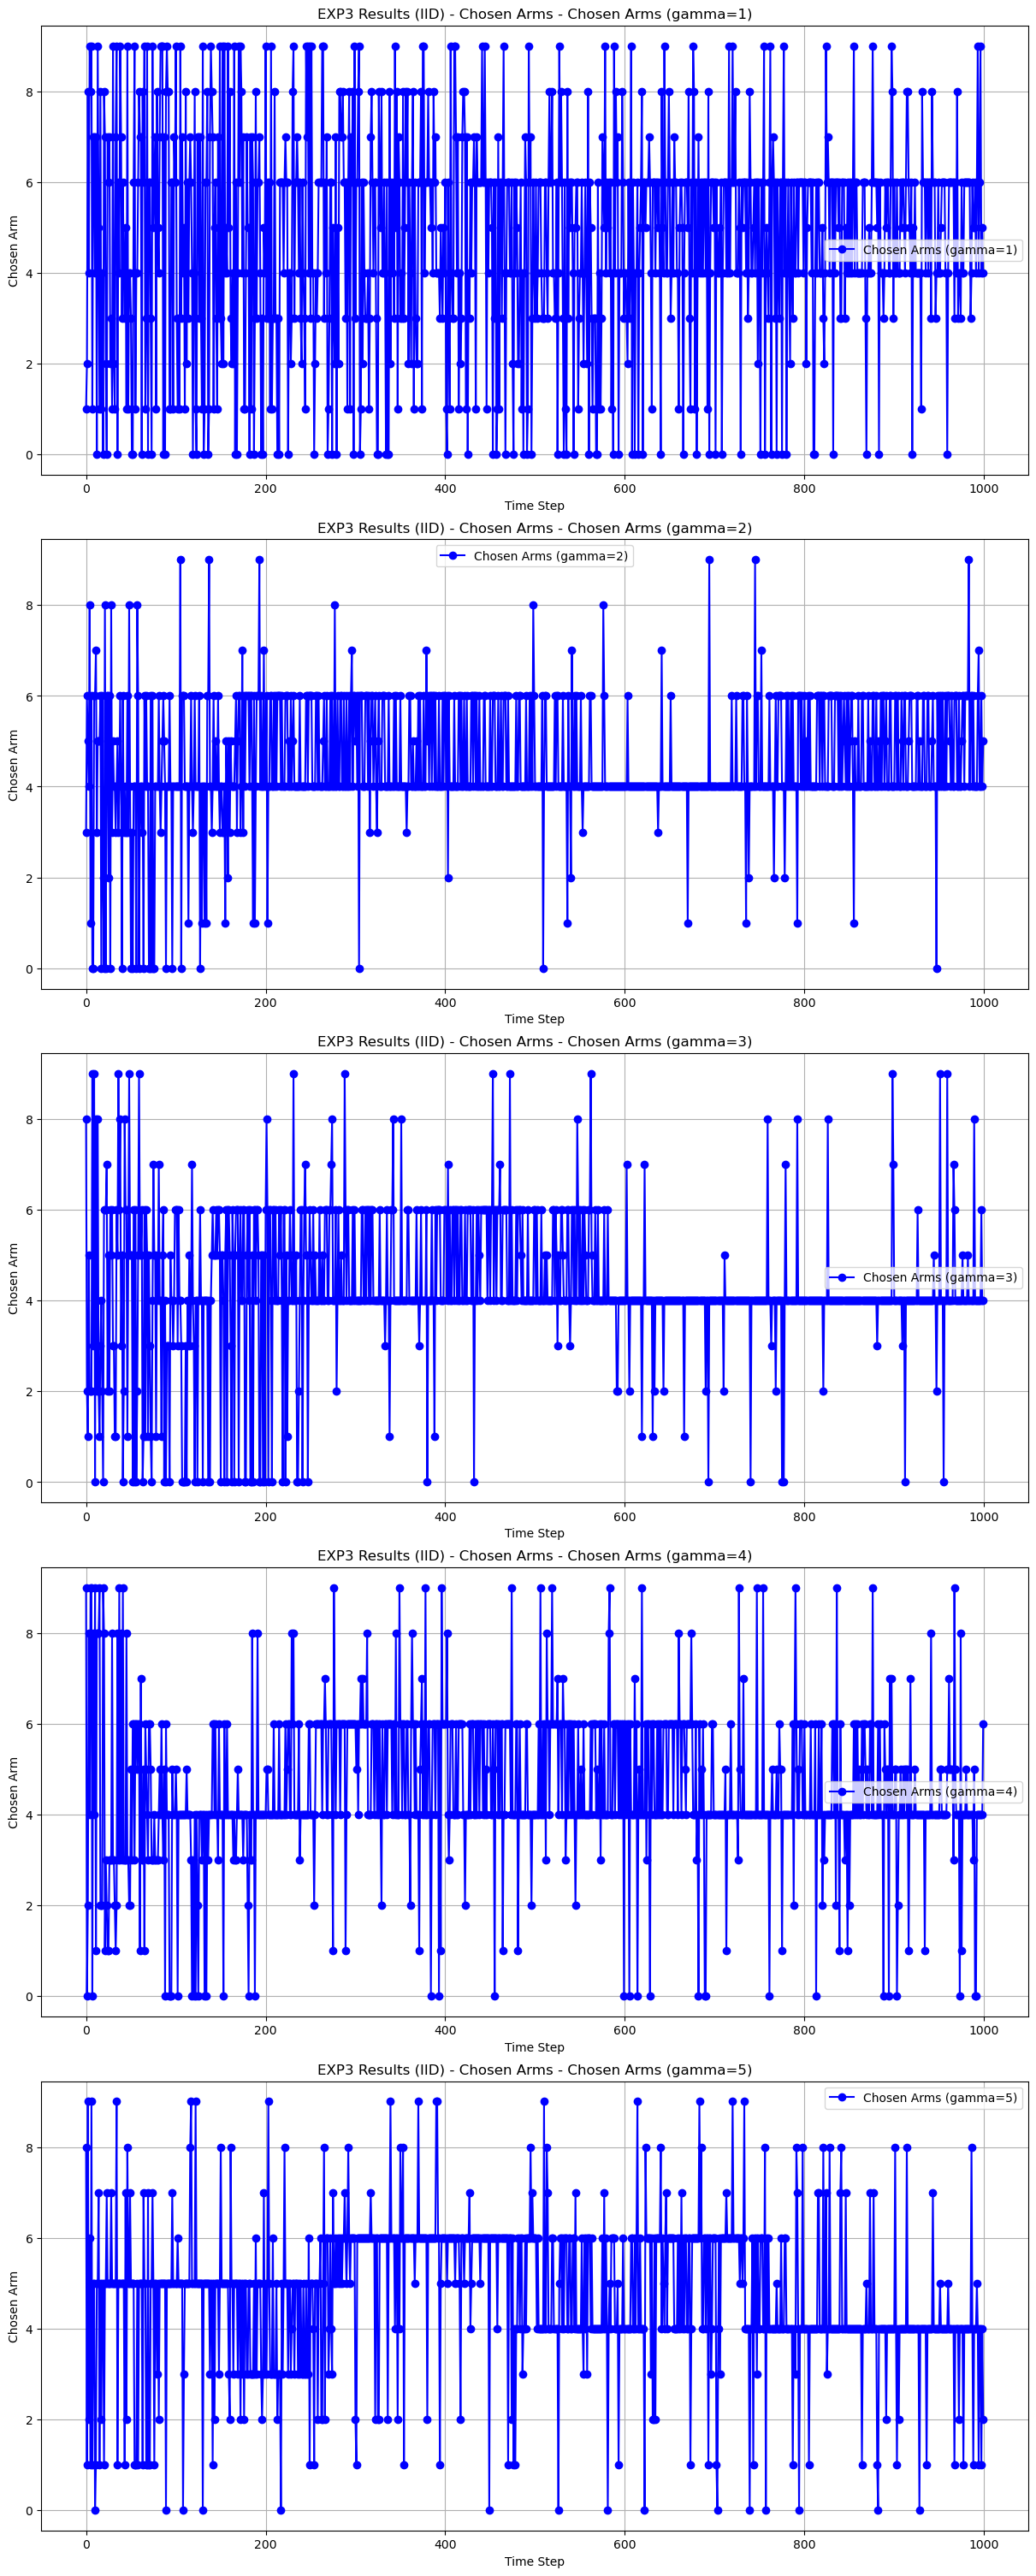

In [166]:
iid_actions, iid_regrets, iid_accuracies = exp3(load_reward_iid, gammas, k_values)
plot_results(iid_actions, iid_regrets, iid_accuracies, gammas, k_values, 'EXP3 Results (IID)')
plot_actions(iid_actions, 'EXP3 Results (IID) - Chosen Arms')

In [167]:
thetas = [0.1, 0.5, 0.9]

Optimal Action: 4, Optimal Reward: 7.738107365733635


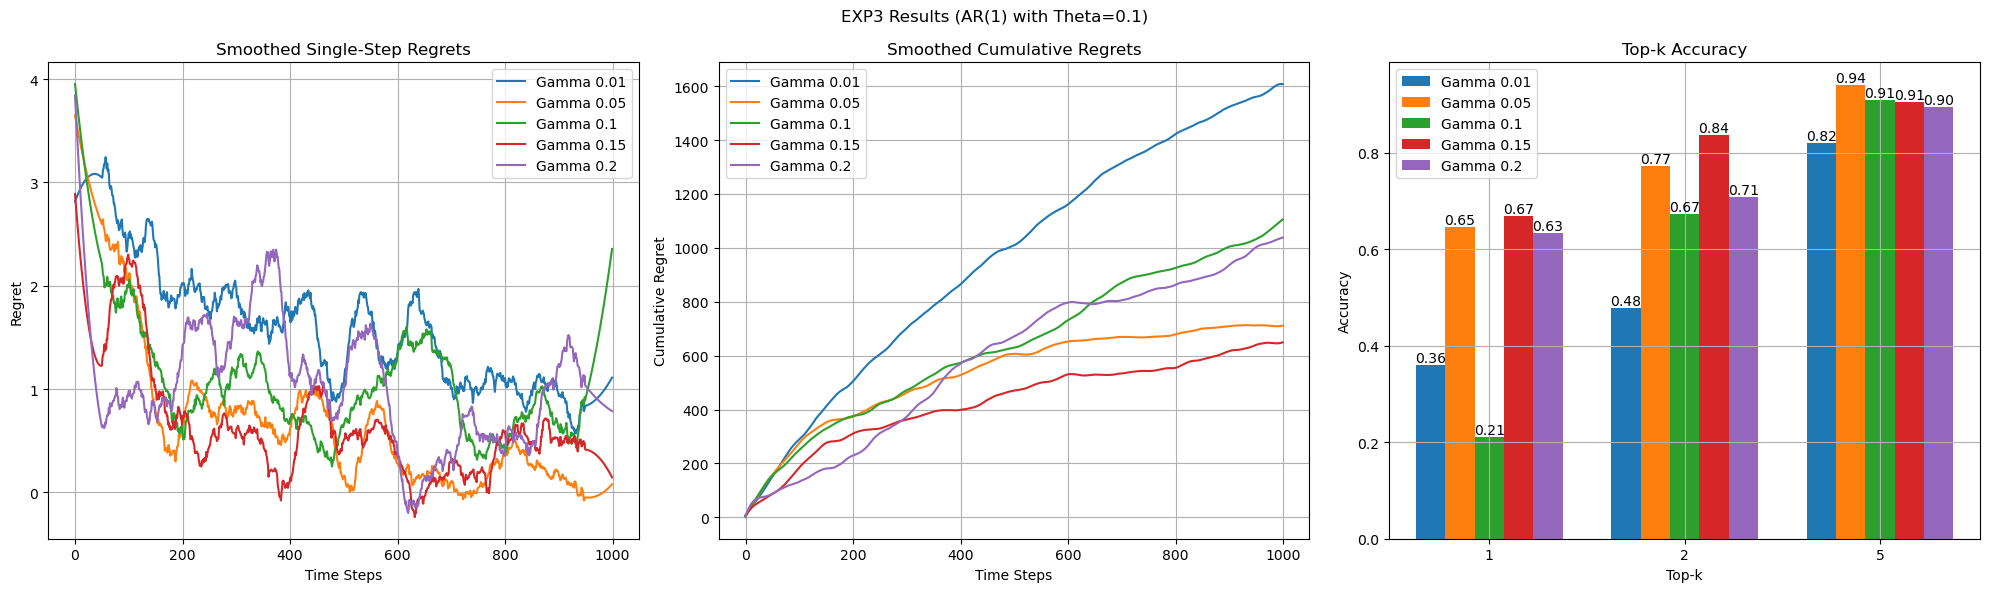

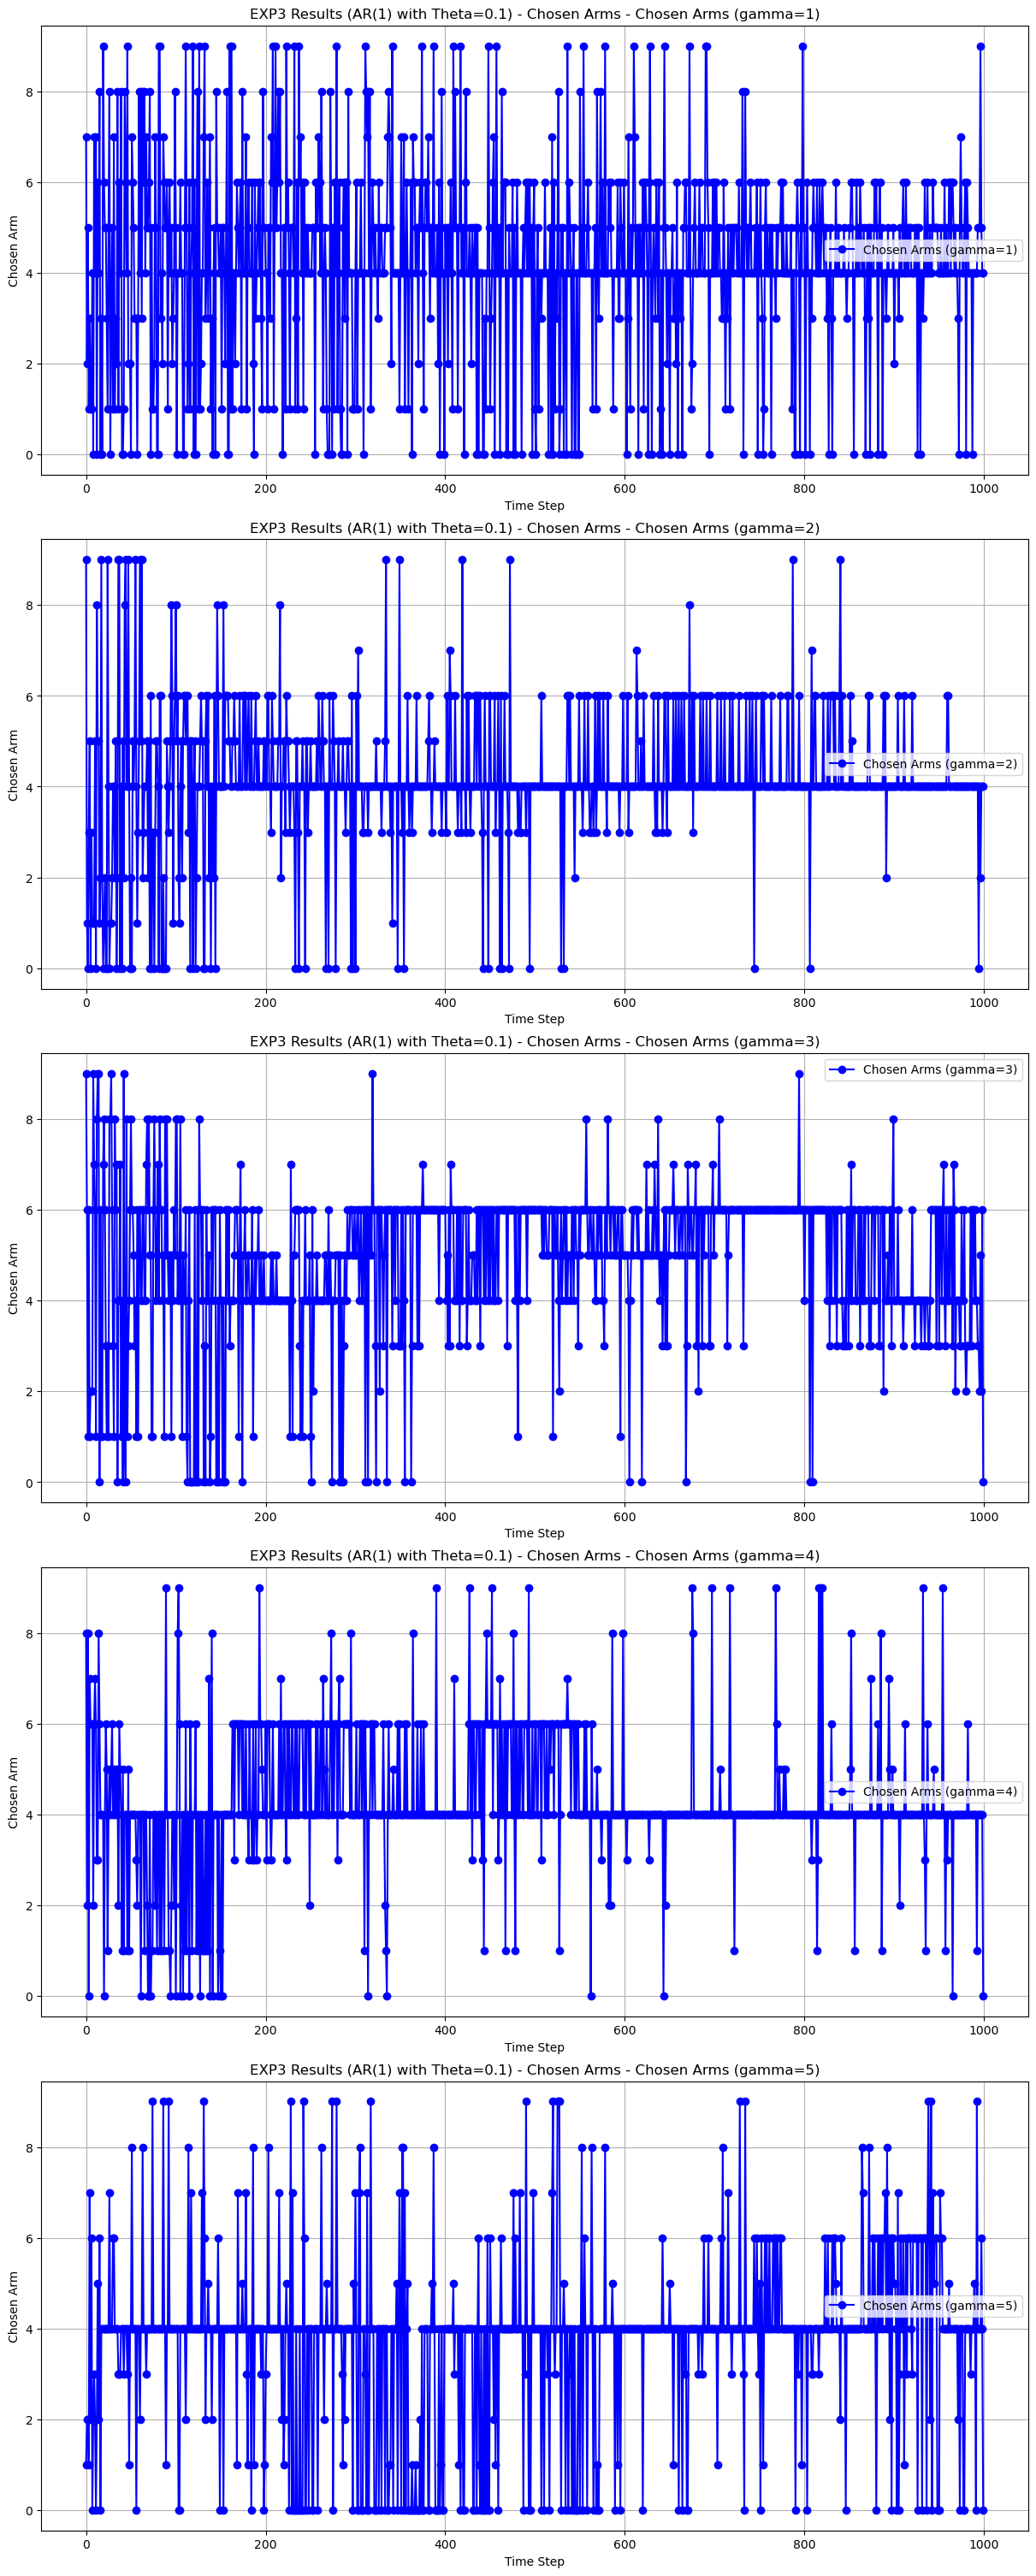

Optimal Action: 4, Optimal Reward: 7.596567420848292


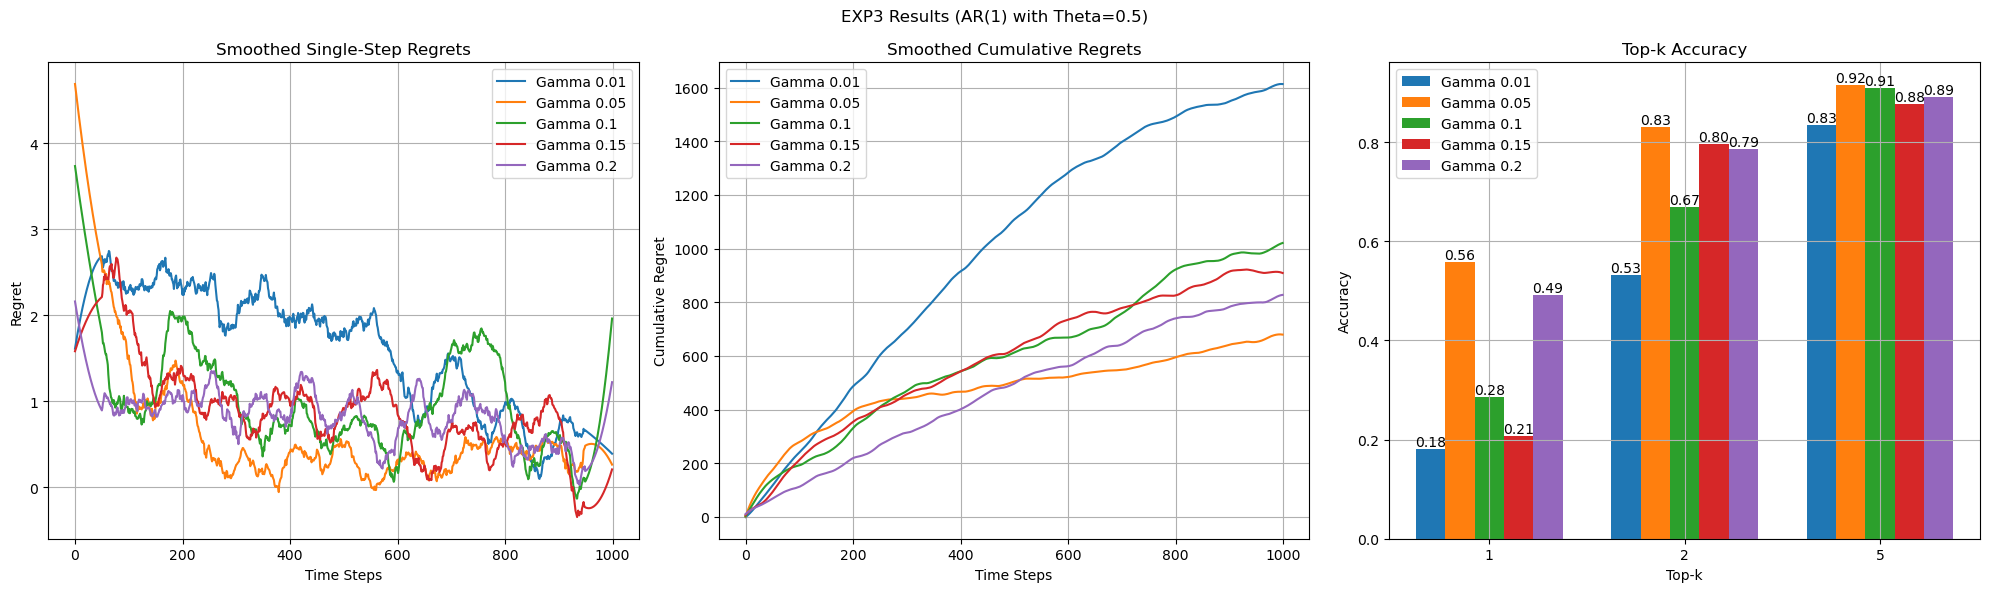

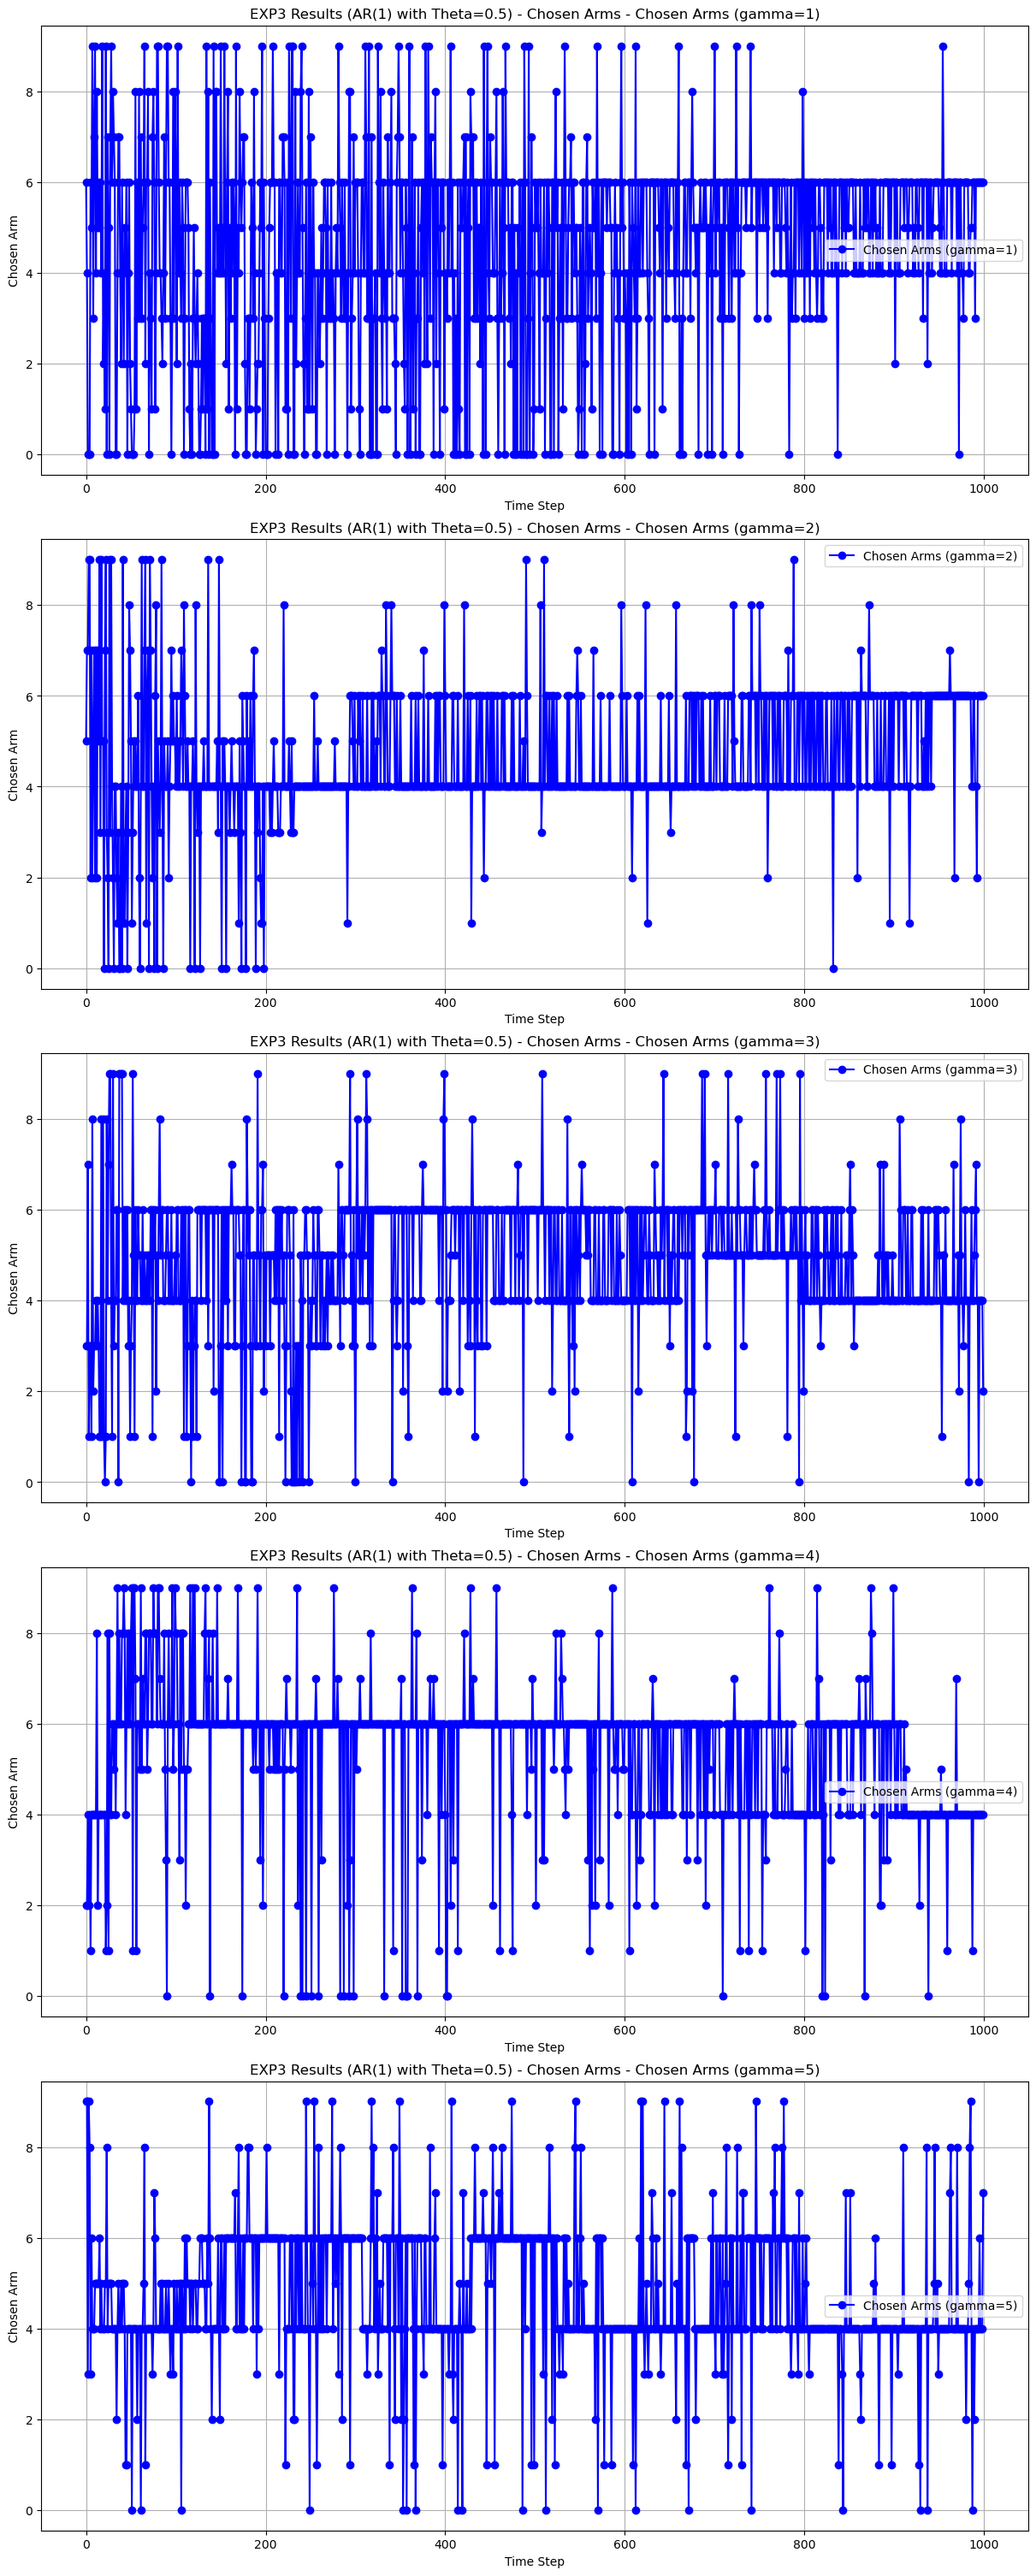

Optimal Action: 4, Optimal Reward: 7.163288460560567


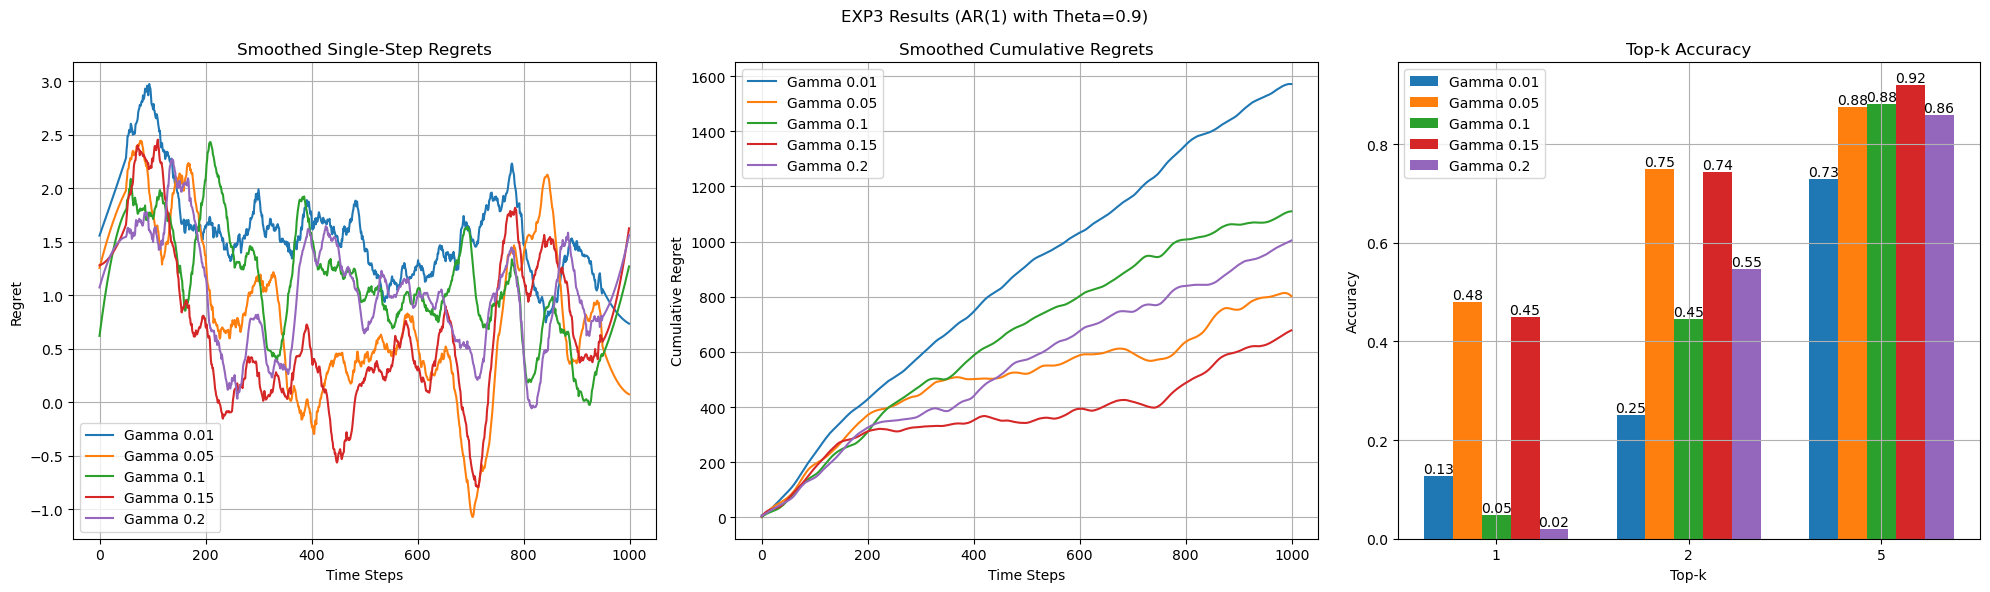

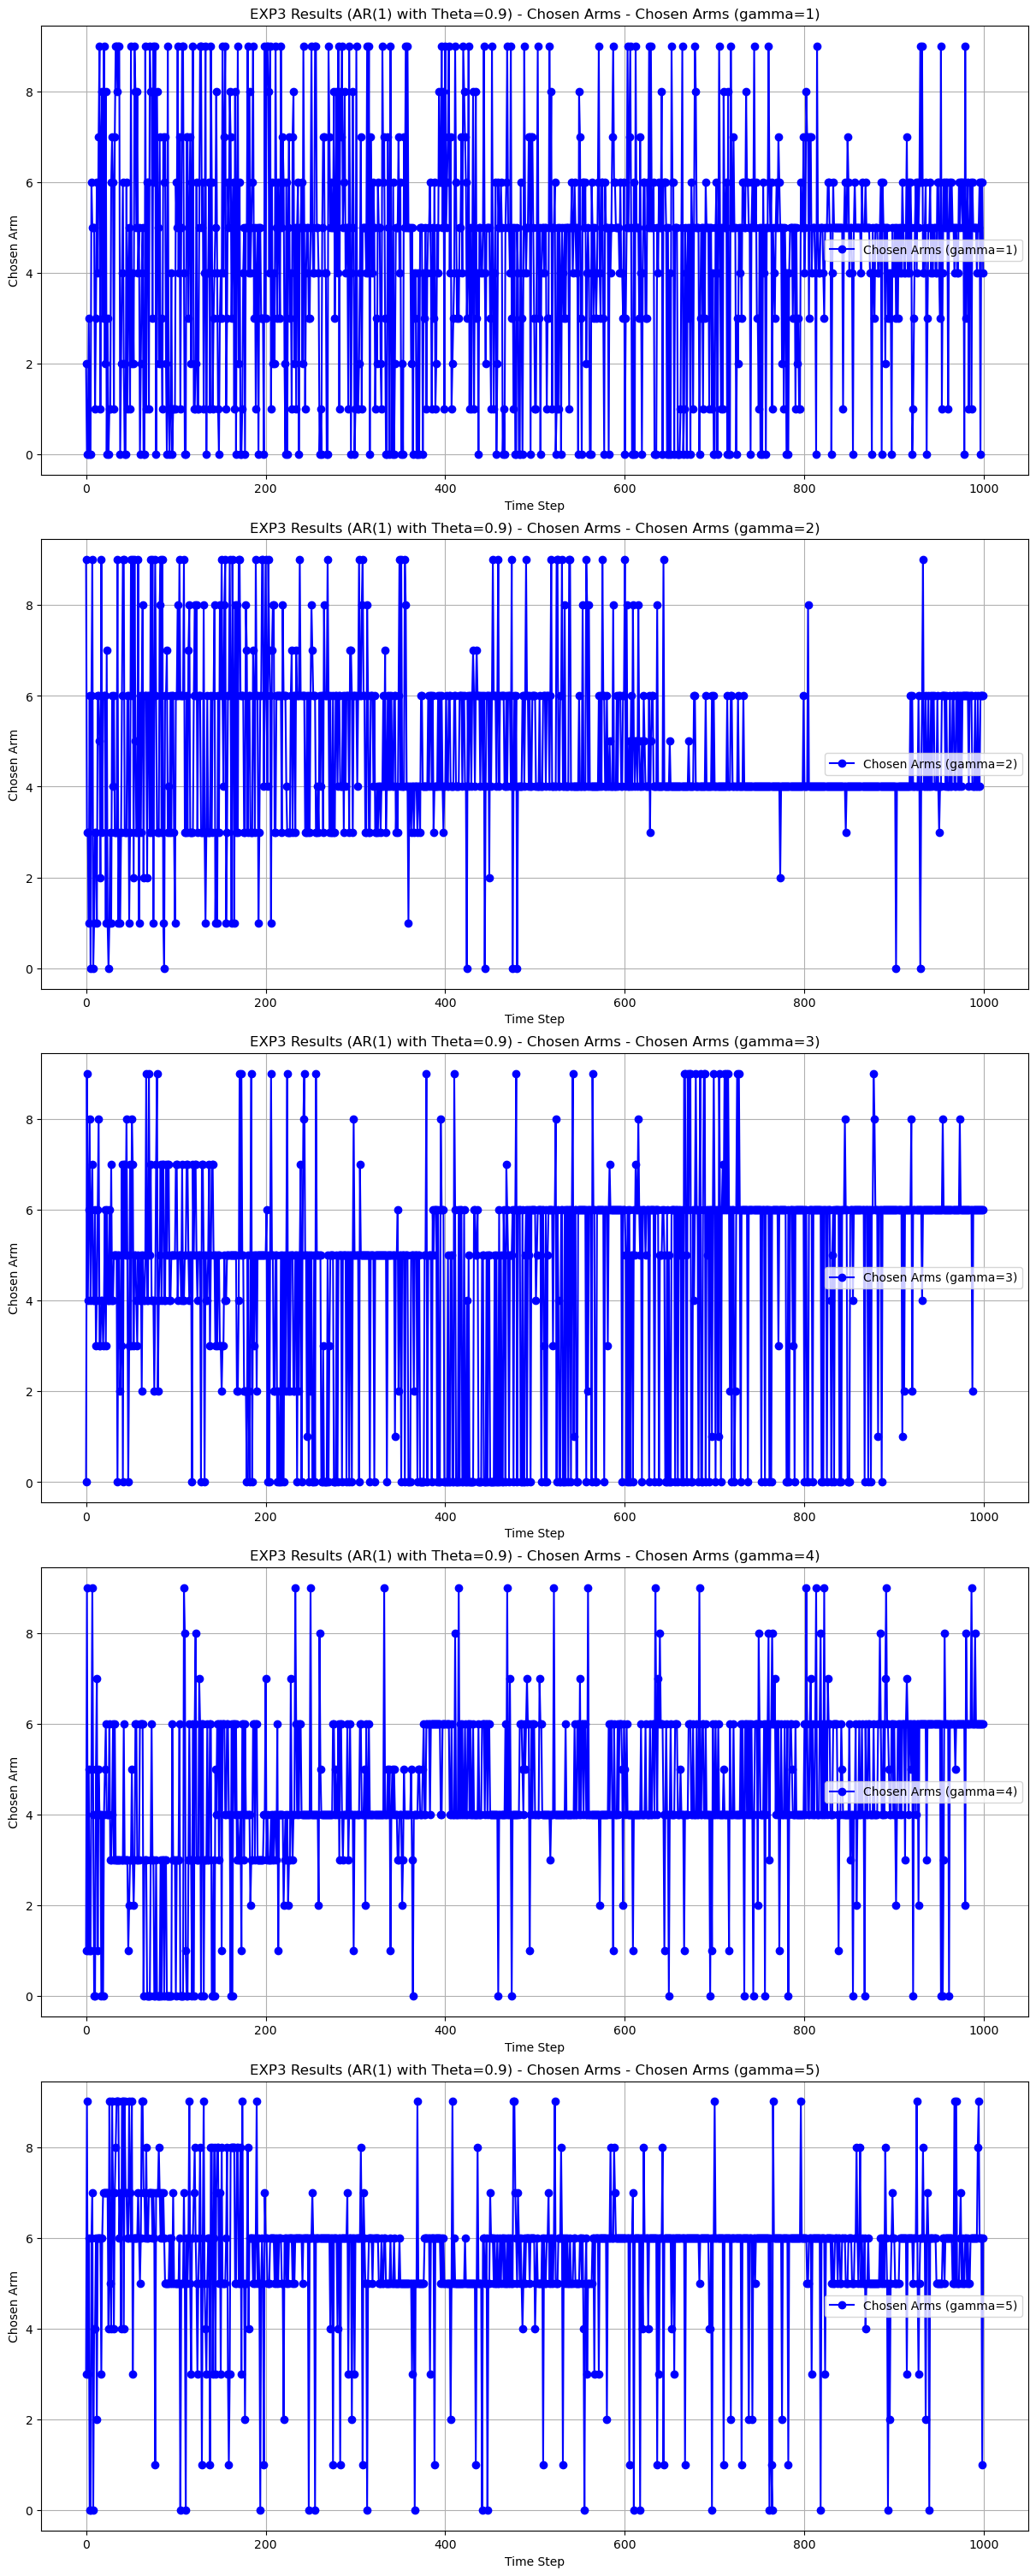

In [168]:
for i, theta in enumerate(thetas):
    ar1_actions, ar1_regrets, ar1_accuracies = exp3(load_reward_ar1_thetas[i], gammas, k_values)
    plot_results(ar1_actions, ar1_regrets, ar1_accuracies, gammas, k_values, f'EXP3 Results (AR(1) with Theta={theta})')
    plot_actions(ar1_actions, f'EXP3 Results (AR(1) with Theta={theta}) - Chosen Arms')
    